In [1]:
from astropy.table import Table
from sklearn import neighbors
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import stats
import pickle
from astropy.io import fits
import random
from astropy.io import ascii
from scipy.integrate import quad
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree

np.set_printoptions(threshold=sys.maxsize)

## Data

In [2]:
data = Table.read('data_flags_updated_Nov1.dat', format = 'ascii')
catalog =data
ra_boolean = np.logical_and(catalog['ra'] > 110, catalog['ra'] < 270)
catalog_north = catalog[ra_boolean]
strip_boolean = np.logical_and.reduce([catalog_north['ra'] > 250, 
                                       catalog_north['ra'] < 269, 
                                       catalog_north['dec'] > 51, 
                                       catalog_north['dec'] < 67])
catalog_main = catalog_north[~strip_boolean]
data = catalog_main

In [3]:
# ra,dec,z
ra = np.array(data['ra'])
dec = np.array(data['dec'])
z = np.array(data['redshift'])

#stellar mass
Mstar = np.array(data['Mstar'])
# Mstar = Mstar[np.logical_not(np.isnan(Mstar))] 
Mstar_NSA= np.array(data['Mstar_NSA'])
# color
u_r = np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))] 

g_r = np.array(data['g_r'])
# g_r = g_r[np.logical_not(np.isnan(g_r))] 

# u_r_NSA = np.array(data['u_r_NSA'])
# g_r_NSA = np.array(data['g_r_NSA'])
# absolute magniture
rabsmag = np.array(data['rabsmag'])
# rabsmag = rabsmag[np.logical_not(np.isnan(rabsmag))] 

rabsmag_NSA = np.array(data['rabsmag_NSA'])
#star formation rate and specific SPR
SFR  = np.array(data['SFR'])
# SFR = SFR[np.logical_not(np.isnan(SFR))] 

sSFR = np.array(data['sSFR'])
# sSFR = sSFR[np.logical_not(np.isnan(sSFR))] 

#classification V^2

wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder

wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

# len(wall_v2)+len(void_v2)+len(edge_v2)+len(out_v2),len(wall_vf)+len(void_vf)+len(edge_vf)+len(out_vf), len(data) #check

In [4]:
all_survey = data[data['redshift']< 0.1026]  # galaxies within the redshift cut

glx_excess= np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8)

wall_vf_excess = np.logical_and(np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8), all_survey['flag_voidfinder'] == 0)
# void_vf_excess = np.logical_and(np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8), all_survey['flag_voidfinder'] == 1)
wall_v2_range = np.logical_and(np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8), all_survey['flag_vsquared'] == 0)
    
wall_v2_excess = np.logical_and(np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8), all_survey['flag_vsquared'] == 0)
void_v2_excess = np.logical_and(np.logical_and(all_survey['rabsmag']>-18.2,all_survey['rabsmag']<-16.8), all_survey['flag_vsquared'] == 1)
    
wall_v2_bool= (all_survey['flag_vsquared'] == 0)
void_vf_bool= (all_survey['flag_voidfinder'] == 1)
wall_vf_bool= (all_survey['flag_voidfinder'] == 0)
void_v2_bool= (all_survey['flag_vsquared'] == 1)



In [38]:
np.sum(wall_v2_excess)

11087

## functions

In [5]:
def ra_dec_z_to_xyz(galaxy_table):
    h=1
    DtoR = np.pi/180.
    RtoD = 180./np.pi
    c = 3e5

    r_gal = c*galaxy_table['redshift'].data/(100*h)
    ra = galaxy_table['ra'].data
    dec = galaxy_table['dec'].data
    
    ra_radian = ra*DtoR

    dec_radian = dec*DtoR

    x_gal = r_gal*np.cos(ra_radian)*np.cos(dec_radian)

    y_gal = r_gal*np.sin(ra_radian)*np.cos(dec_radian)

    z_gal = r_gal*np.sin(dec_radian)

    num_gal = x_gal.shape[0]

    gals_xyz = np.concatenate((x_gal.reshape(num_gal,1),
                                     y_gal.reshape(num_gal,1),
                                     z_gal.reshape(num_gal,1)), axis=1)
    return gals_xyz

In [93]:


galaxy_table_all=all_survey

galaxy_table_xyz_all=ra_dec_z_to_xyz(galaxy_table_all)


X1 = galaxy_table_xyz_all
Y1= galaxy_table_xyz_all

kdt = KDTree(X1, leaf_size=30, metric='euclidean')
dist, ind= kdt.query(Y1, k=2, return_distance=True) # distance to neirest neighbor of wall galaxies from all galaxies
# indices of two closes neighbors
# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(Y1)
# distances, indices = nbrs.kneighbors(X1)
# distances_=distances[:,1]


# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(Y1)
# distances, indices = nbrs.kneighbors(X1)

In [113]:
# wall_v2_range = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 0)
#     void_v2_rand = np.logical_and(np.logical_and(all_survey['rabsmag']>b,all_survey['rabsmag']<a), all_survey['flag_vsquared'] == 1)
# galaxy_type=wall_v2_bool
# galaxy_table_wall=all_survey[galaxy_type]

galaxy_type=wall_vf_bool

galaxy_table_wall=all_survey[galaxy_type]
galaxy_table_xyz_wall=ra_dec_z_to_xyz(galaxy_table_wall)

X2 = galaxy_table_xyz_wall
Y2= galaxy_table_xyz_wall

kdt2 = KDTree(Y2, leaf_size=30, metric='euclidean')
dist2, ind2= kdt.query(X2, k=2, return_distance=True) # distance to neirest neighbor of wall galaxies from all galaxies
# indices of two closes neighbors



In [96]:
near_all_ind= ind[:,1] # indices of neirest neighbors of wall galaxies from all sample
near_all_dist= dist[:,1] # indices of neirest neighbors of wall galaxies from all sample

In [97]:
wallv2_near_ind = near_all_ind[wall_v2_bool]
wallv2_near_dist=near_all_dist[wall_v2_bool]

wallvf_near_ind = near_all_ind[wall_vf_bool]
wallvf_near_dist=near_all_dist[wall_vf_bool]

wallv2_excess_near_ind = near_all_ind[wall_v2_excess]
wallv2_excess_near_dist=near_all_dist[wall_v2_excess]



SyntaxError: invalid syntax (<ipython-input-103-10b8647a49f6>, line 1)

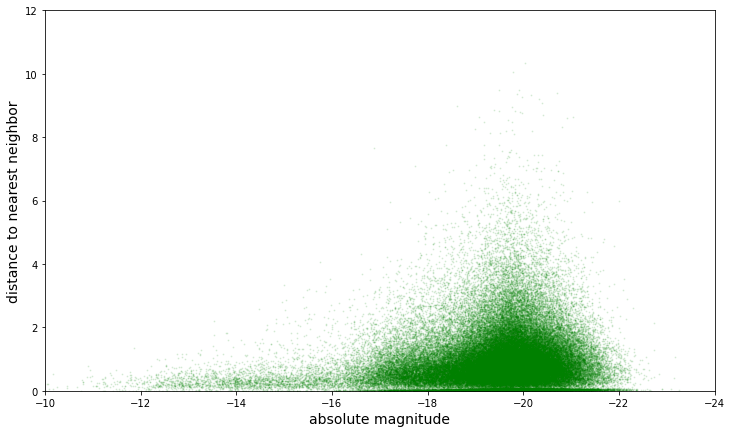

In [98]:
plt.figure(figsize=(12,7))

plt.scatter(all_survey['rabsmag'][wall_v2_bool],wallv2_near_dist,alpha=0.1, s=1, color="g") # void vf # [galaxy_type]
plt.ylim(0,12)
plt.xlim(-10,-24)
plt.xlabel("absolute magnitude", fontsize=14)
# plt.title("WALL V2")
plt.ylabel("distance to nearest neighbor", fontsize=14)
plt.show()# the deeper objects are brighter

In [70]:
len(wallv2_near_ind), len((all_survey['rabsmag'])[wall_vf_bool])

(99884, 190864)

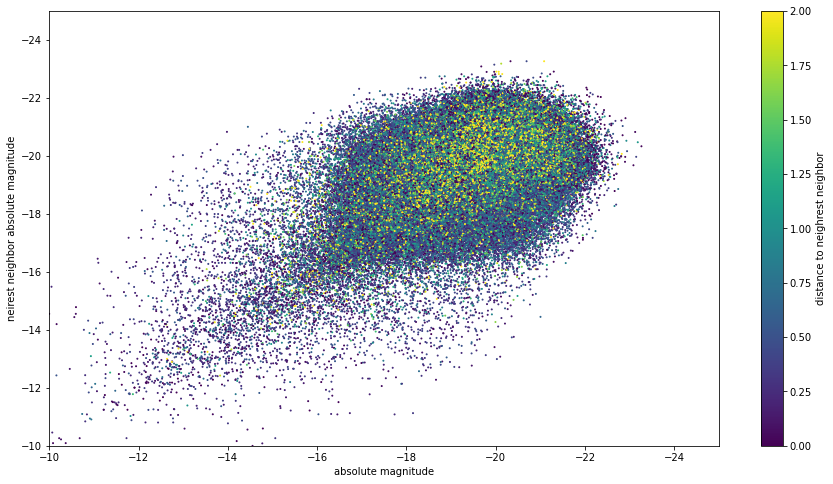

In [101]:
cm = plt.cm.get_cmap()

plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'],all_survey["rabsmag"][near_all_ind],c=near_all_dist ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]

bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()

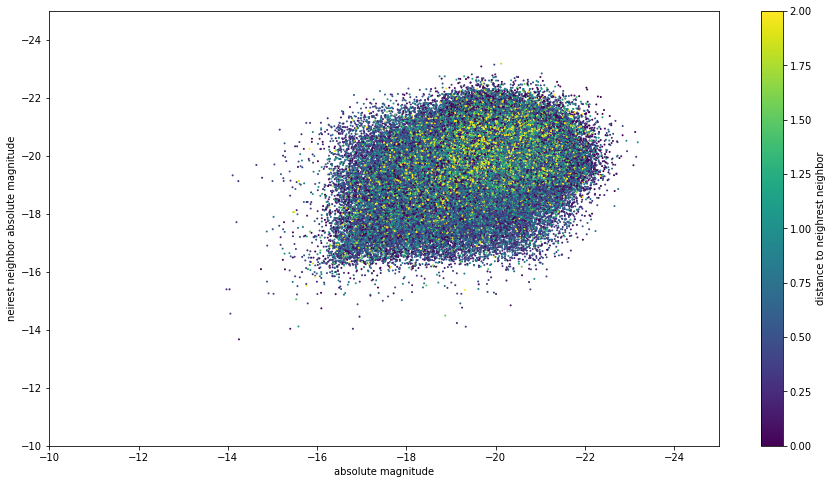

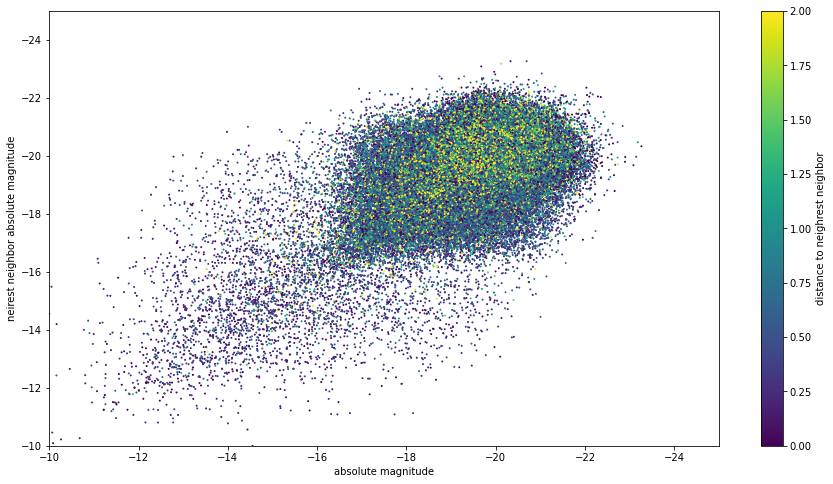

In [88]:
cm = plt.cm.get_cmap()

plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][wall_vf_bool],data["rabsmag"][wallvf_near_ind],c=wallvf_near_dist ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]

bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()


cm = plt.cm.get_cmap()

plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][wall_v2_bool],data["rabsmag"][wallv2_near_ind],c=wallv2_near_dist ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]

bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()





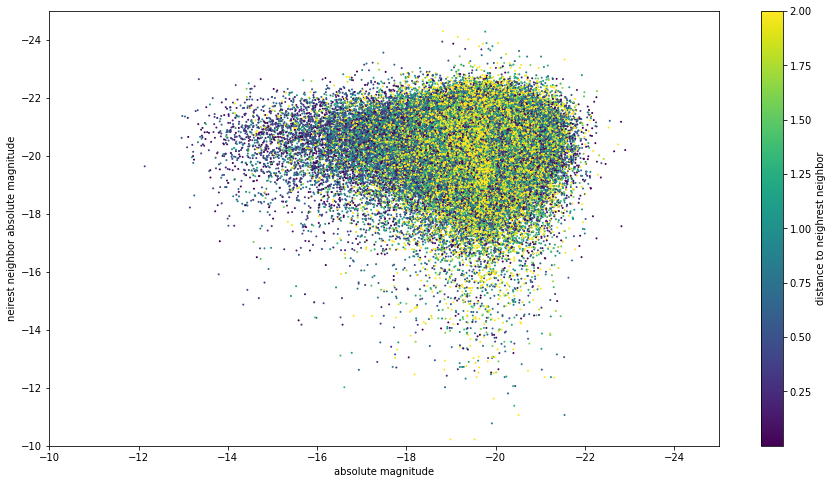

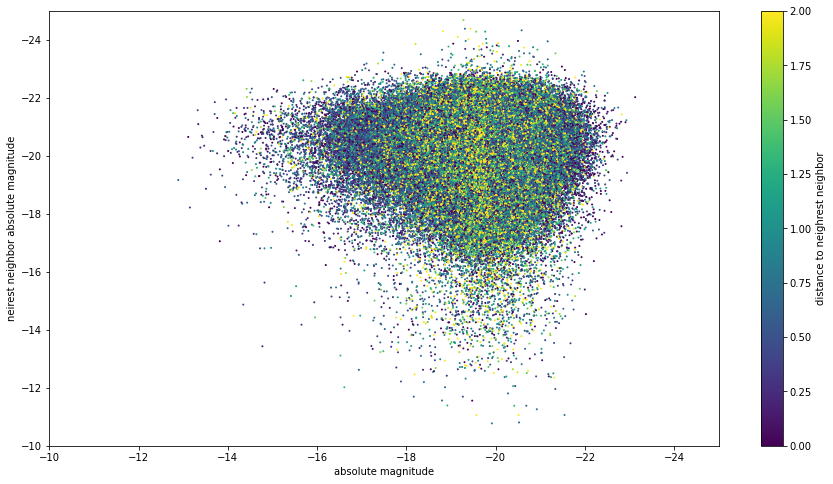

In [100]:
cm = plt.cm.get_cmap()

plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][void_vf_bool],data["rabsmag"][near_all_ind[void_vf_bool]],c=near_all_dist[void_vf_bool] ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]

bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()


cm = plt.cm.get_cmap()

plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][void_v2_bool],data["rabsmag"][near_all_ind[void_v2_bool]],c=near_all_dist[void_v2_bool] ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]

bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()





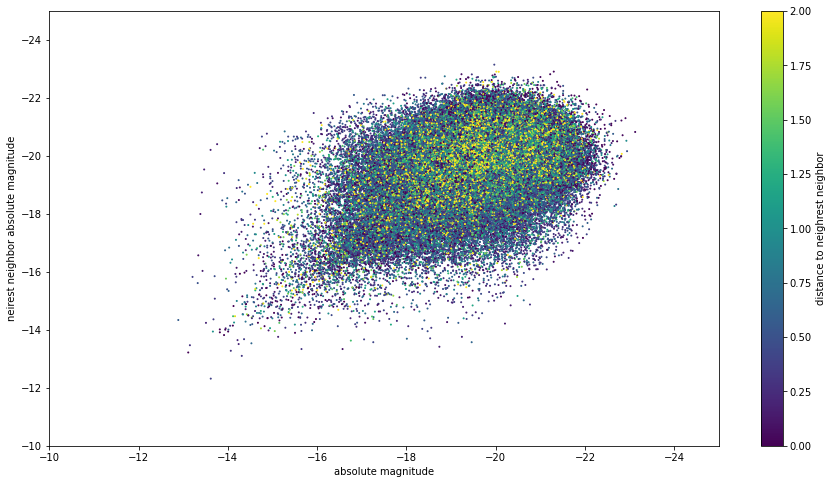

In [109]:
# cm = plt.cm.get_cmap()

# plt.subplots(figsize=(15,8))
# sc = plt.scatter(all_survey['rabsmag'][void_vf_bool],data["rabsmag"][near_all_ind[void_vf_bool]],c=near_all_dist[void_vf_bool] ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]

# bar2= plt.colorbar(sc)
# plt.ylim(-10,-25)
# plt.xlim(-10,-25)
# plt.xlabel("absolute magnitude")
# plt.ylabel("neirest neighbor absolute magnitude")
# bar2.set_label("distance to neighrest neighbor")
# plt.show()


cm = plt.cm.get_cmap()

plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][void_v2_bool],all_survey["rabsmag"][ind2[:,1]],c=dist2[:,1] ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]

bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()





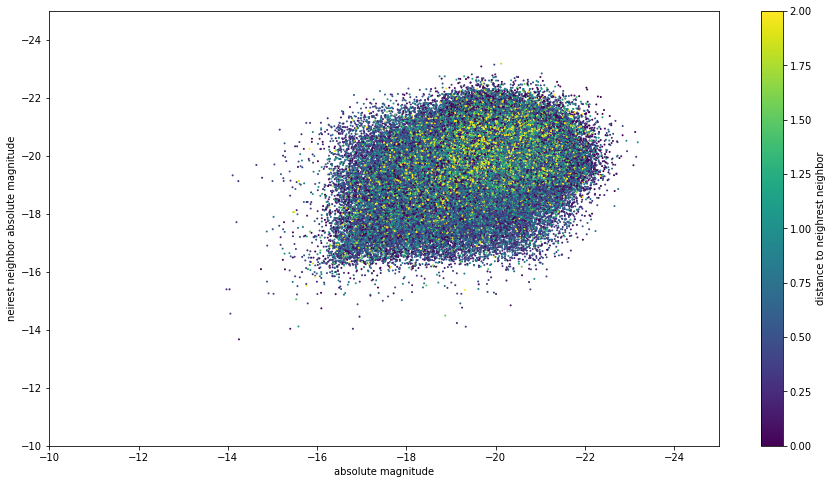

In [114]:
plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][wall_vf_bool],all_survey["rabsmag"][ind2[:,1]],c=dist2[:,1] ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]

bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()


IndexError: index 527104 is out of bounds for axis 0 with size 333381

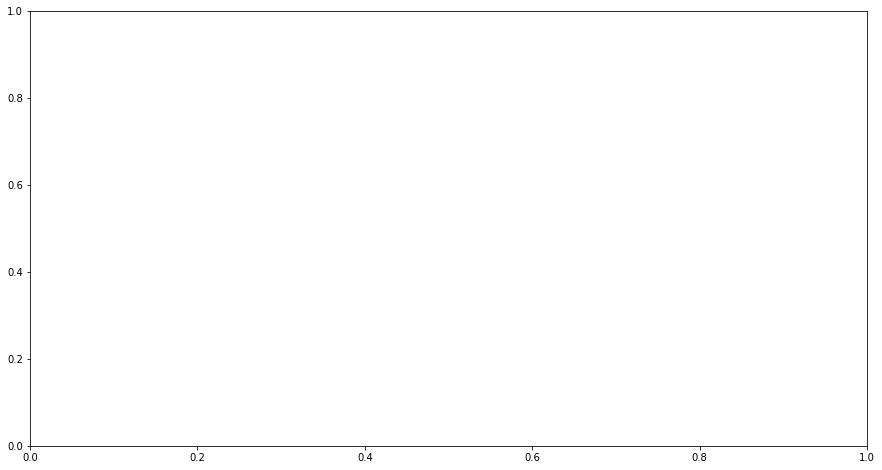

In [89]:
cm = plt.cm.get_cmap()

plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][wall_vf_bool],all_survey["rabsmag"][wallv2_near_ind],c=wallv2_near_dist ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]

bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()



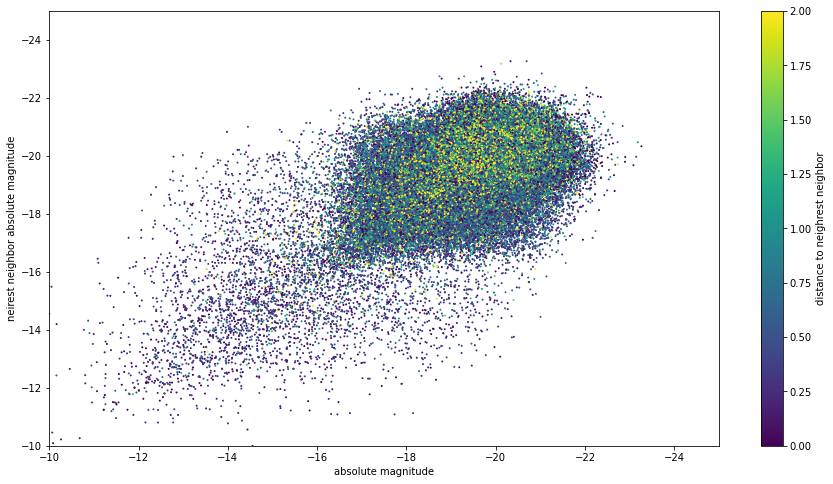

In [72]:
cm = plt.cm.get_cmap()

plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][wall_v_bool],all_survey["rabsmag"][wallv2_near_ind],c=wallv2_near_dist ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]
# sc = plt.scatter(all_survey['rabsmag'][wall_v2_excess],all_survey["rabsmag"][wallv2_excess_near_ind],c=wallv2_excess_near_dist ,vmax=2,s=1, ) # void vf # [galaxy_type]

bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()



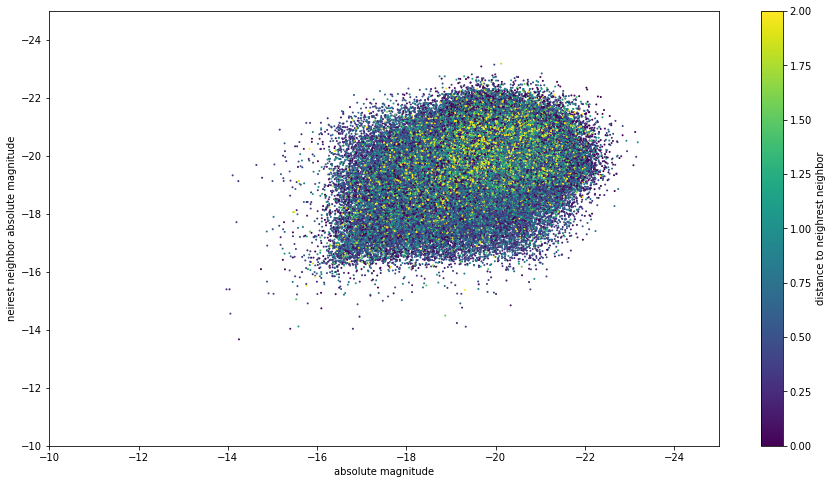

In [80]:
cm = plt.cm.get_cmap()

plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][wall_vf_bool],all_survey["rabsmag"][ind2[:,1]],c=dist2[:,1] ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]

bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()



In [7]:
abs_mag_diff=all_survey[galaxy_type]["rabsmag"]-all_survey[indices[:,1]]["rabsmag"]

In [8]:
mass_diff=all_survey[galaxy_type]["Mstar"]-all_survey[indices[:,1]]["Mstar"]

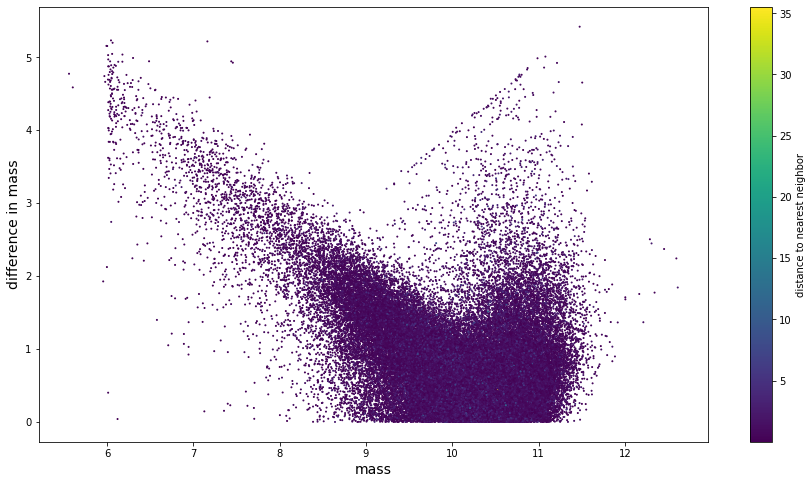

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey[galaxy_type]['Mstar'],np.abs(mass_diff),c=distances_ ,s=1,cmap=cm) # void vf # [galaxy_type]
# plt.ylim(0,12)
# plt.ylim(-10,-24)
# plt.xlim(-10,-24)
plt.xlabel("mass", fontsize=14)
k = plt.colorbar(sc)
k.set_label('distance to nearest neighbor')
# ax.set(facecolor = "black")
# plt.title("WALL V2")
plt.ylabel("difference in mass", fontsize=14)
plt.show()# the deeper objects are brighter

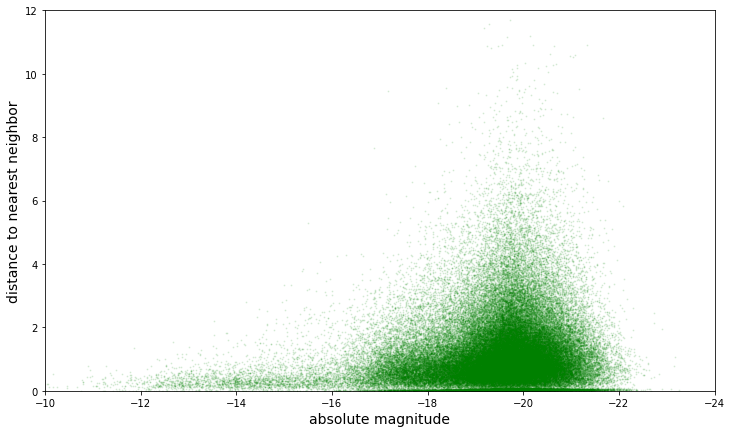

In [14]:
plt.figure(figsize=(12,7))

plt.scatter(all_survey['rabsmag'][wall_v2_bool],,alpha=0.1, s=1, color="g") # void vf # [galaxy_type]
plt.ylim(0,12)
plt.xlim(-10,-24)
plt.xlabel("absolute magnitude", fontsize=14)
# plt.title("WALL V2")
plt.ylabel("distance to nearest neighbor", fontsize=14)
plt.show()# the deeper objects are brighter

In [ ]:
plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][wall_v2_bool],all_survey[indices[:,1]]["rabsmag"],c=distances_ ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]
bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()

ValueError: x and y must be the same size

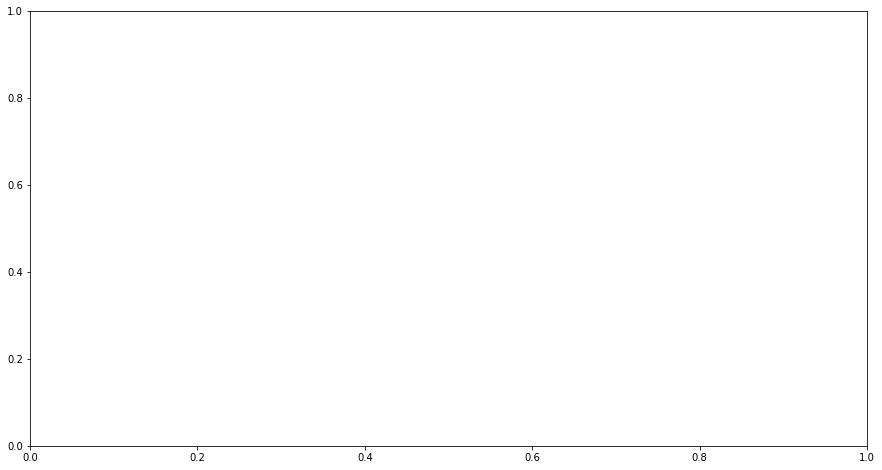

In [69]:
plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][wall_v2_bool],all_survey[indices[:,1]]["rabsmag"],c=dist[:,1] ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]
bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()


ValueError: x and y must be the same size

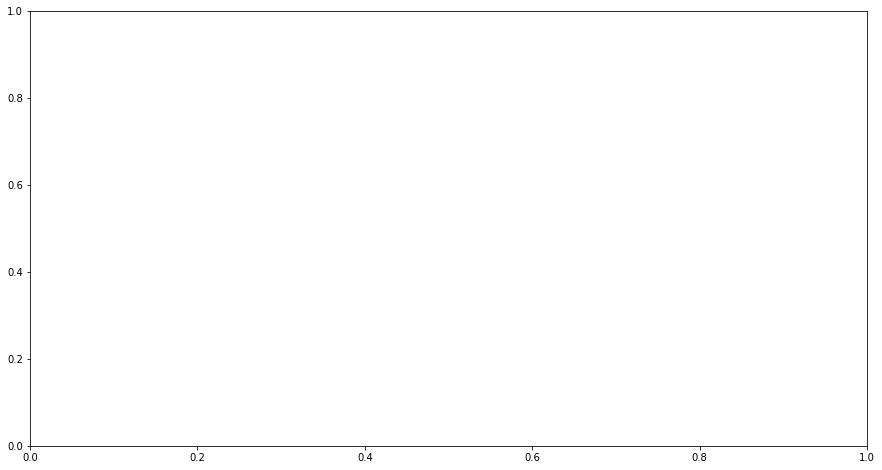

In [67]:
cm = plt.cm.get_cmap()

plt.subplots(figsize=(15,8))
sc = plt.scatter(all_survey['rabsmag'][wall_vf_bool],all_survey["rabsmag"][ind[:,1]],c=distances_ ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]
bar2= plt.colorbar(sc)
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
bar2.set_label("distance to neighrest neighbor")
plt.show()



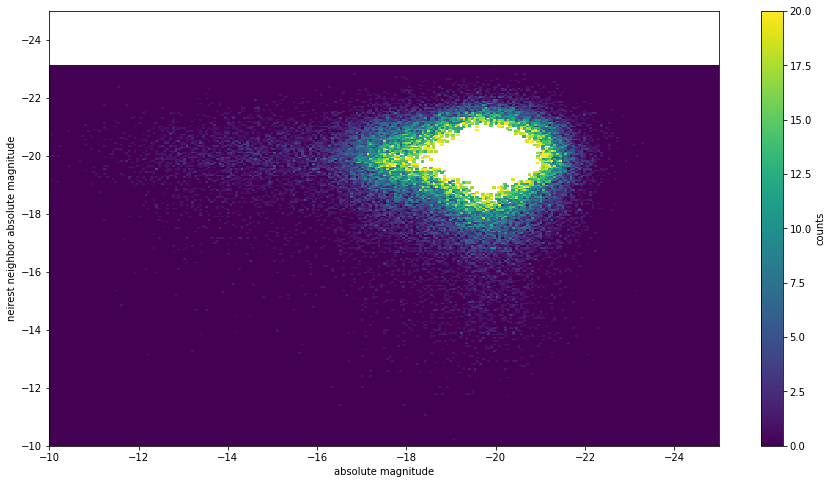

In [20]:
plt.subplots(figsize=(15,8))
h = plt.hist2d(all_survey['rabsmag'][wall_v2_bool], all_survey[indices[:,1]]["rabsmag"], bins=400, cmax=20) # [galaxy_type]
bar1= plt.colorbar(h[3])
bar1.set_label("counts")
plt.ylim(-10,-25)
plt.xlim(-10,-25)
plt.xlabel("absolute magnitude")
plt.ylabel("neirest neighbor absolute magnitude")
plt.show()

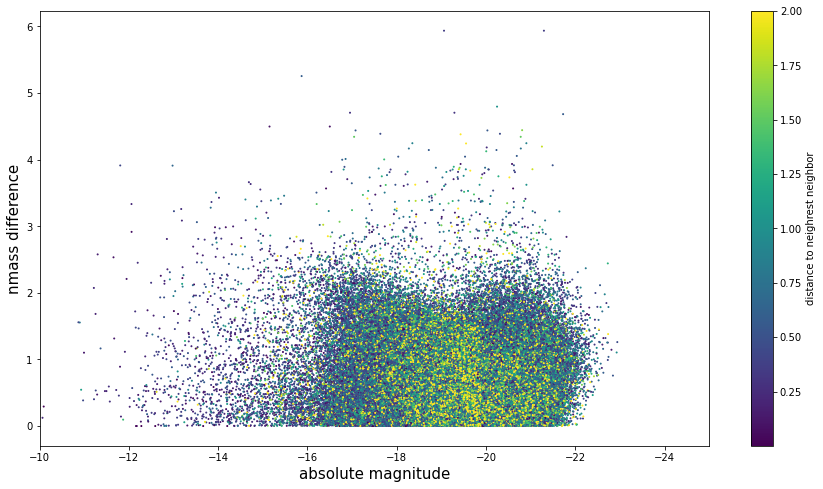

In [74]:
plt.subplots(figsize=(15,8))
# h = plt.hist2d(all_survey['rabsmag'], np.abs(mass_diff), bins=400) # [galaxy_type]
sc = plt.scatter(all_survey['rabsmag'],np.abs(mass_diff),c=distances_ ,vmax=2,s=1, cmap=cm) # void vf # [galaxy_type]
# bar1= plt.colorbar(h[3])
bar2= plt.colorbar(sc)
plt.xlim(-10,-25)

plt.xlabel("absolute magnitude", fontsize=15)
plt.ylabel("nmass difference", fontsize=15)
# bar1.set_label("distance to neir", fontsize=15)
bar2.set_label("distance to neighrest neighbor")
plt.show()



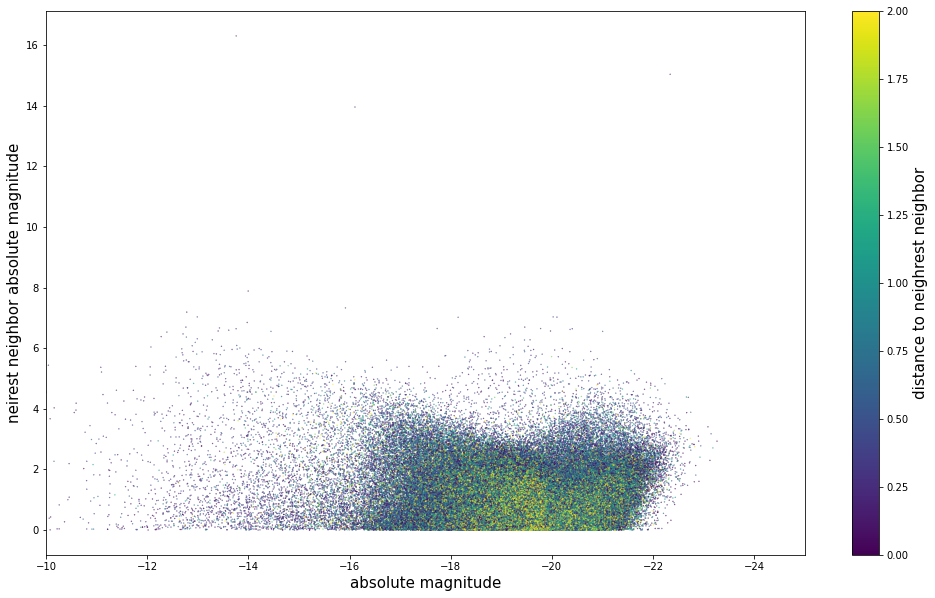

In [64]:
plt.subplots(figsize=(17,10))
# h = plt.hist2d(all_survey['rabsmag'], all_survey[indices[:,1]]["rabsmag"], bins=400, cmax=20) # [galaxy_type]
sc = plt.scatter(all_survey['rabsmag'],np.abs(abs_mag_diff),c=distances_ ,vmax=2,s=0.1, cmap=cm) # void vf # [galaxy_type]
# bar1= plt.colorbar(h[3])
bar2= plt.colorbar(sc)
plt.xlim(-10,-25)
plt.xlim(-10,-25)

plt.xlabel("absolute magnitude", fontsize=15)
plt.ylabel("neirest neighbor absolute magnitude", fontsize=15)
bar1.set_label("counts")
bar2.set_label("distance to neighrest neighbor", fontsize=15)
plt.show()



<IPython.core.display.Javascript object>


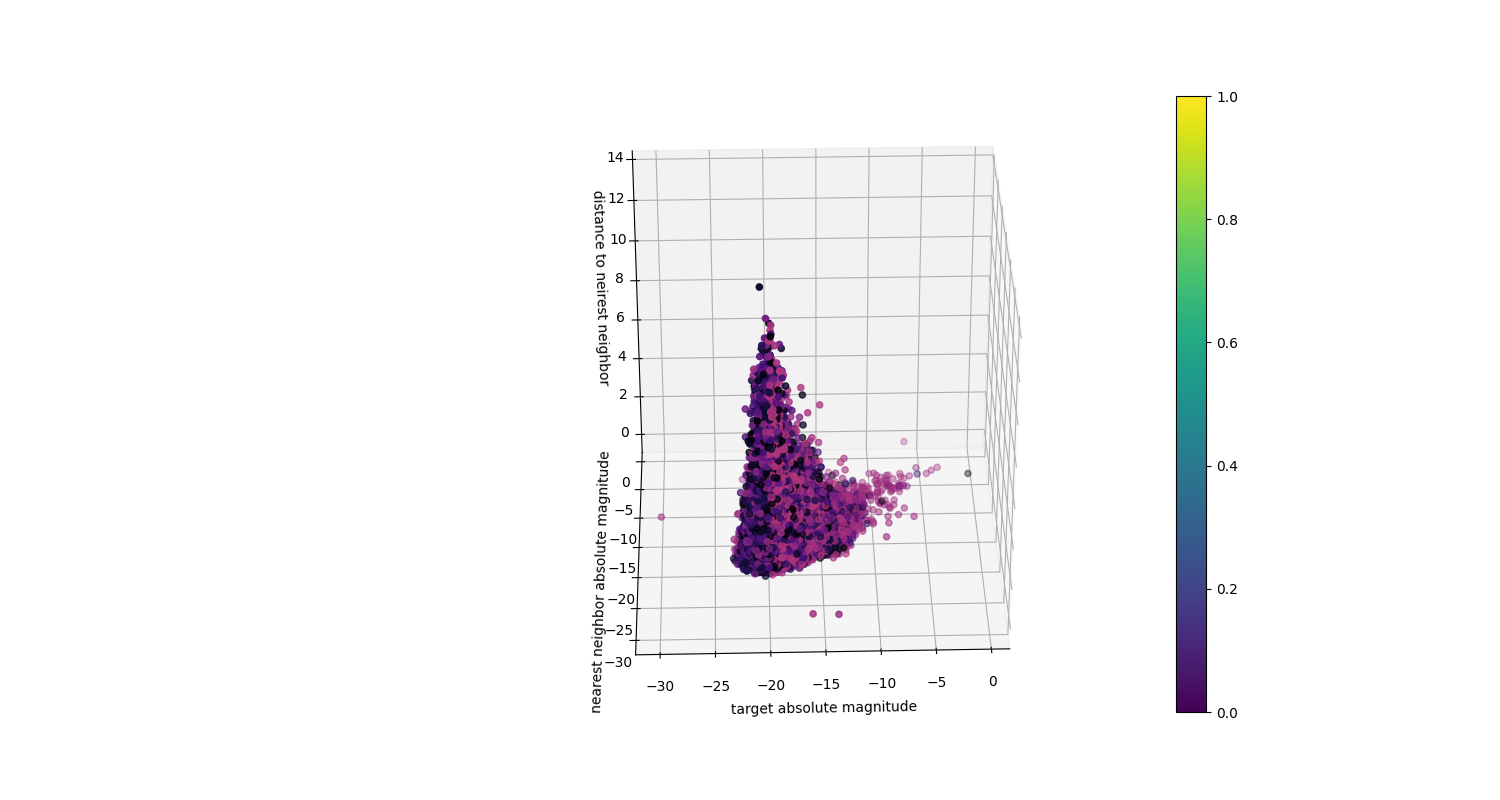

In [33]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')


x, y, z = all_survey['rabsmag'], all_survey[indices[:,1]]["rabsmag"], distances_
c = np.arange(len(x)) / len(x)  # create some colours

p = ax.scatter(x, y, z, c=plt.cm.magma(0.5*c))
ax.set_xlabel('target absolute magnitude')
ax.set_ylabel('nearest neighbor absolute magnitude')
ax.set_zlabel('distance to neirest neighbor')

ax.set_box_aspect([np.ptp(i) for i in data])  # equal aspect ratio

fig.colorbar(p, ax=ax)

In [88]:
most luminous objects in our galaxy?

Object `galaxy` not found.


In [ ]:
most luminous objects in our galaxy